In [ ]:
# Uncomment and run this in you python environment
# !pip install tensorflow matplotlib sklearn opencv-python

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, LeakyReLU, MaxPooling2D, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
import random
from PIL import Image

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# image libraries
import cv2

import warnings
warnings.filterwarnings("ignore")

In [ ]:
image_dataset_path = "/kaggle/input/ai-vs-human-generated-dataset/"
train_df = pd.read_csv(image_dataset_path + "train.csv")
train_df["file_name"] = image_dataset_path + train_df["file_name"]

train_df.head()

,Unnamed: 0,file_name,label
0,0,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
1,1,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
2,2,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
3,3,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
4,4,/kaggle/input/ai-vs-human-generated-dataset/tr...,1


In [3]:
train_df=train_df.drop('Unnamed: 0',axis=1)

In [ ]:
ai_images = train_df[train_df["label"] == 1]["file_name"].tolist()
human_images = train_df[train_df["label"] == 0]["file_name"].tolist()

# Function to display images
def show_images(image_paths, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random.sample(image_paths, num_images)):
        img = Image.open(img_path)  # Open image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()

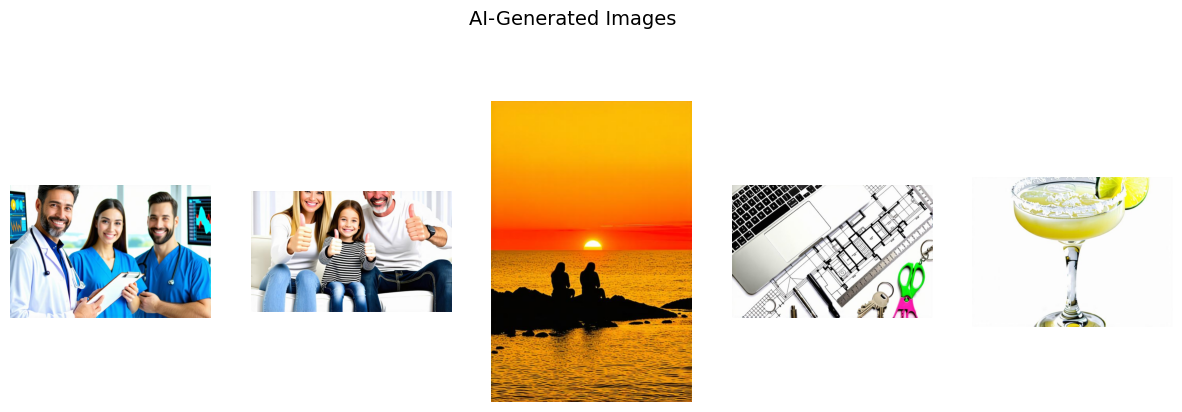

In [5]:
show_images(ai_images, "AI-Generated Images")

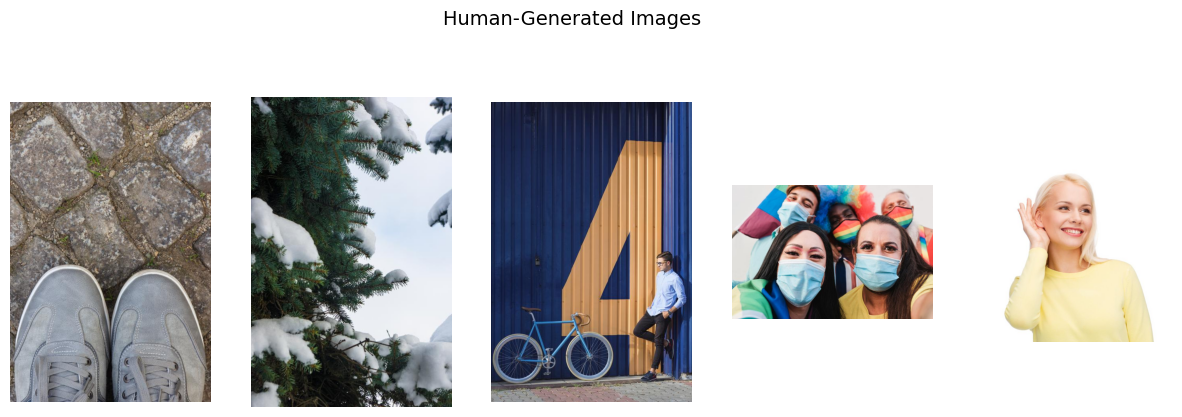

In [6]:
show_images(human_images, "Human-Generated Images")

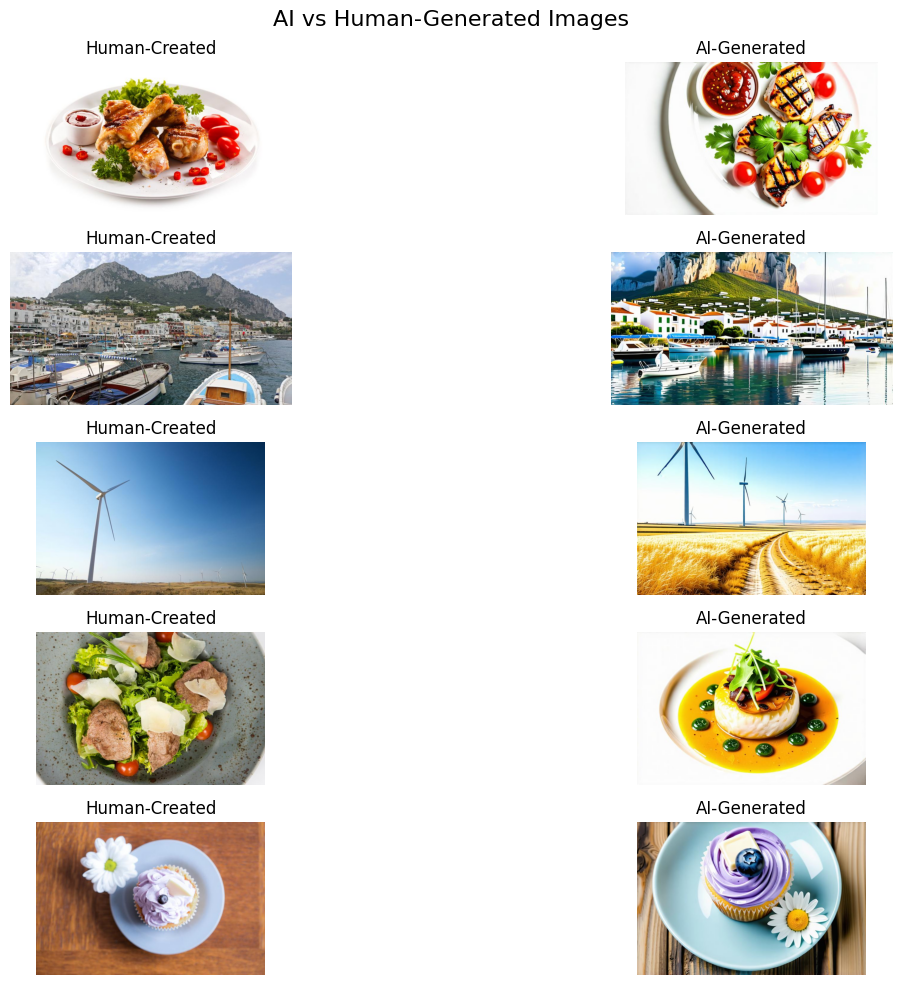

In [ ]:
def show_ai_vs_human(df, num_images=5):
    ai_images = df[df["label"] == 1]["file_name"].dropna().sample(num_images, random_state=42).values
    human_images = df[df["label"] == 0]["file_name"].dropna().sample(num_images, random_state=42).values

    plt.figure(figsize=(15, num_images * 2))
    
    for i, (ai_img_path, human_img_path) in enumerate(zip(ai_images, human_images)):
        # Read AI Image
        ai_img = cv2.imread(ai_img_path)
        human_img = cv2.imread(human_img_path)

        if ai_img is None or human_img is None:
            print(f"Skipping missing images: {ai_img_path} or {human_img_path}")
            continue  # Skip missing images
        
        ai_img = cv2.cvtColor(ai_img, cv2.COLOR_BGR2RGB)
        human_img = cv2.cvtColor(human_img, cv2.COLOR_BGR2RGB)

        # Show Human Image
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(human_img)
        plt.axis("off")
        plt.title("Human-Created")

        # Show AI Image
        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(ai_img)
        plt.axis("off")
        plt.title("AI-Generated")

    plt.suptitle("AI vs Human-Generated Images", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display images
show_ai_vs_human(train_df)

In [ ]:
image_dataset_path = "/kaggle/input/ai-vs-human-generated-dataset/"
test_df = pd.read_csv(image_dataset_path + "test.csv")
test_df["file_path"] = image_dataset_path + test_df["id"] 

test_df.head()

,id,file_path
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...


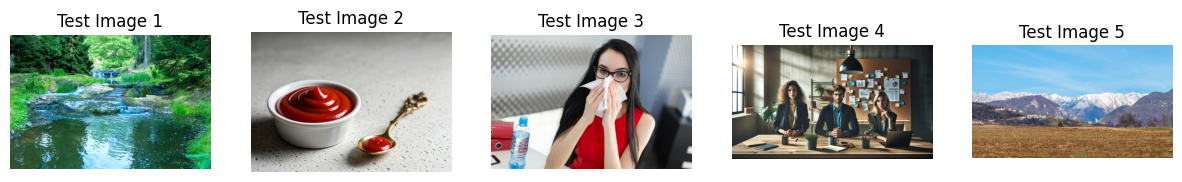

In [ ]:
def show_test_images(df, num_images=5):
    sample_images = df.sample(num_images, random_state=42)["file_path"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Test Image {i+1}")
        
    plt.show()

show_test_images(test_df)

In [10]:
train_df["label"] = train_df["label"].astype(str)

In [ ]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

In [20]:
train_generator = data_generator.flow_from_dataframe(
    train_df,
    x_col="file_name",   
    y_col="label",      
    target_size=(128, 128),  
    batch_size=16,
    class_mode="binary",
    subset="training")

valid_generator = data_generator.flow_from_dataframe(
    train_df,
    x_col="file_name",
    y_col="label",
    target_size=(128, 128),
    batch_size=16,
    class_mode="binary",
    subset="validation")

Found 63960 validated image filenames belonging to 2 classes.
Found 15990 validated image filenames belonging to 2 classes.


In [ ]:
model = Sequential([

    # 1st Conv Block
    Conv2D(32, (3, 3), padding="same", input_shape=(128, 128, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Reduced Dropout

    # 2nd Conv Block
    Conv2D(64, (3, 3), padding="same"),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # 3rd Conv Block
    Conv2D(128, (3, 3), padding="same"),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # 4th Conv Block (removed 5th)
    Conv2D(256, (3, 3), padding="same"),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Global Average Pooling Instead of Flatten
    GlobalAveragePooling2D(),

    # Fully Connected Layer
    Dense(256),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),  # Slightly reduced Dropout

    # Output Layer
    Dense(1, activation='sigmoid')
])

In [22]:
METRICS = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall')]

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# Print a summary of the model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 457,409 (1.74 MB)

 Trainable params: 455,937 (1.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [23]:
%%time
history = model.fit(train_generator, 
                    epochs=20, 
                    validation_data=valid_generator)

Epoch 1/20
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 263s 63ms/step - accuracy: 0.8656 - loss: 0.3307 - precision: 0.8776 - recall: 0.8473 - val_accuracy: 0.8824 - val_loss: 0.2841 - val_precision: 0.9735 - val_recall: 0.7862
Epoch 2/20
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 246s 62ms/step - accuracy: 0.9050 - loss: 0.2393 - precision: 0.9111 - recall: 0.8966 - val_accuracy: 0.8636 - val_loss: 0.3069 - val_precision: 0.9929 - val_recall: 0.7325
Epoch 3/20
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 238s 59ms/step - accuracy: 0.9423 - loss: 0.1560 - precision: 0.9435 - recall: 0.9406 - val_accuracy: 0.7931 - val_loss: 0.4806 - val_precision: 0.9981 - val_recall: 0.5874
Epoch 4/20
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 235s 59ms/step - accuracy: 0.9586 - loss: 0.1111 - precision: 0.9574 - recall: 0.9603 - val_accuracy: 0.9067 - val_loss: 0.2354 - val_precision: 0.9927 - val_recall: 0.8194
Epoch 5/20
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 237s 59ms/step - accuracy: 0.9669 - loss: 0.0965 - precision: 0.9664 - recall: 0.9676 - val_accura

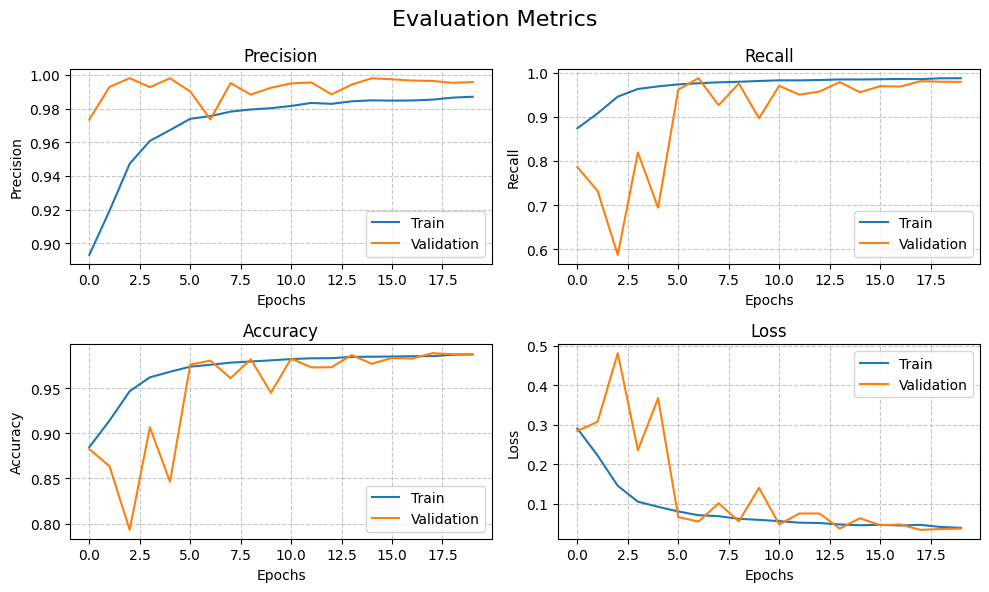

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
fig.suptitle("Evaluation Metrics", fontsize=16)  # ✅ Main title

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    if met in history.history:
        ax[i].plot(history.history[met])
        ax[i].plot(history.history.get('val_' + met, []))

        ax[i].set_title(f'{met.capitalize()}')  # ✅ Individual metric title
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(met.capitalize())
        ax[i].legend(['Train', 'Validation'])
        ax[i].grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [37]:
test_generator = data_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_path",   
    y_col=None,         
    target_size=(128, 128),  
    batch_size=16,
    class_mode=None,     
    shuffle=False        
)

Found 5540 validated image filenames.


In [38]:
predictions = model.predict(test_generator)

347/347 ━━━━━━━━━━━━━━━━━━━━ 195s 560ms/step


In [39]:
predicted_labels = (predictions > 0.5).astype(int) 

In [40]:
submission_df = pd.DataFrame({
    'id': test_df['id'],  
    'label': predicted_labels.flatten()  
})

submission_df.to_csv('submission.csv', index=False)

print(submission_df.head())

                                                  id  label
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg      0
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg      0
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg      0
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg      0
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg      0


In [41]:
submission_df['label'].value_counts()

label
0    5047
1     493
Name: count, dtype: int64

In [52]:
base = "/kaggle/input/ai-vs-human-generated-dataset/"

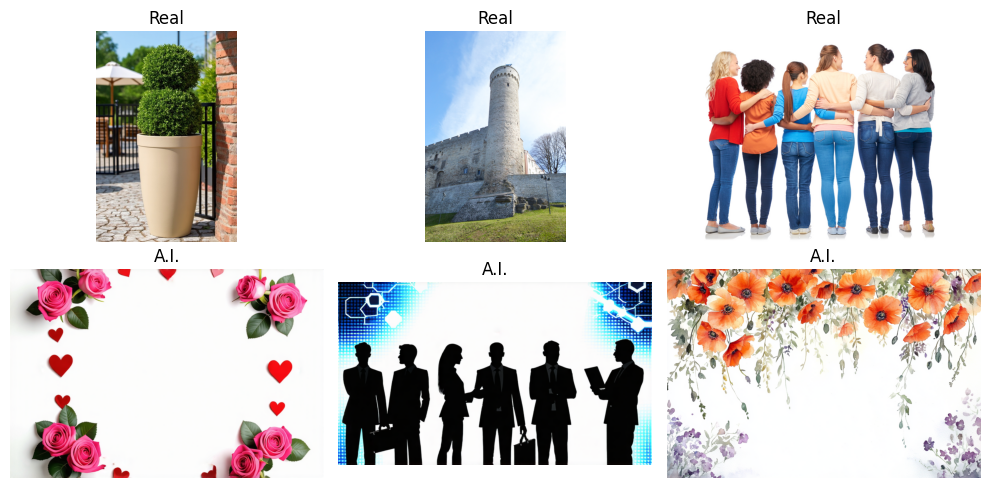

In [57]:
samples = submission_df.groupby('label').apply(lambda x: x.sample(3)).reset_index(drop=True)

# Plot the images
fig, axes = plt.subplots(len(samples['label'].unique()), 3, figsize=(10, 5))

for i, (img_path, label) in enumerate(zip(base+samples['id'], samples['label'])):
    img = cv2.imread(img_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    row = label  # Row based on class label
    col = i % 3  # Ensure 3 images per row

    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    if label == 0:
        axes[row, col].set_title('Real')
    else:
        axes[row, col].set_title('A.I.')

plt.tight_layout()
plt.show()

In [42]:
model.save('model.h5')  # Saves the entire model (architecture + weights)
print("Model Saved successfully!")

Model Saved successfully!
